In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


In [2]:
# load datasets
train_data = pd.read_csv('data/train-dataset.csv', delimiter=',')
test_data = pd.read_csv('data/test-dataset.csv', delimiter=',')
dev_data = pd.read_csv('data/dev-dataset.csv', delimiter=',')

# divide input and output values
x_train = train_data.drop('TROPTHSMesswert', axis=1)
y_train = train_data['TROPTHSMesswert']

x_test = test_data.drop('TROPTHSMesswert', axis=1)
y_test = test_data['TROPTHSMesswert']

x_dev = dev_data.drop('TROPTHSMesswert', axis=1)
y_dev = dev_data['TROPTHSMesswert']

In [3]:
regressor = RandomForestRegressor(n_estimators=250, random_state=0, oob_score=True)
regressor.fit(x_train, y_train)

RandomForestRegressor(n_estimators=250, oob_score=True, random_state=0)

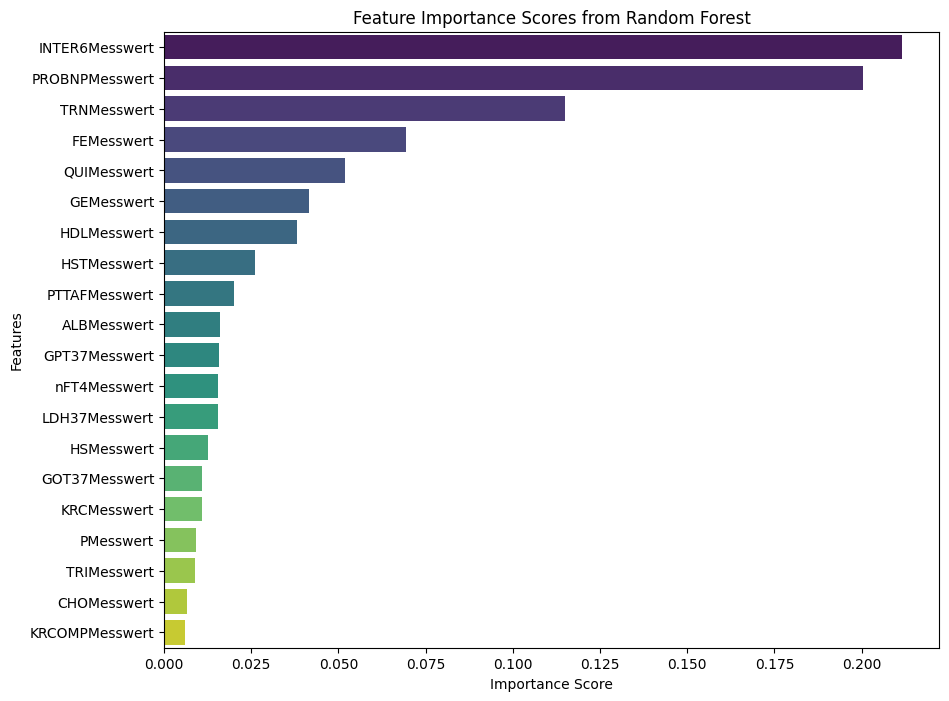

In [4]:
#Implementing featuer importance
feature_importance = regressor.feature_importances_
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_20_features = feature_importance_df.head(20)

# plot the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Scores from Random Forest')
plt.show()

### Evaluation with all Features

In [5]:
# evaluation with all features
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

pred_dev = regressor.predict(x_dev)
pred_test = regressor.predict(x_test)

#Metrics
mae_dev = mean_absolute_error(y_dev, pred_dev)
mae_test = mean_absolute_error(y_test, pred_test)
mse_dev = mean_squared_error(y_dev, pred_dev)
mse_test = mean_squared_error(y_test, pred_test)
r2_dev = r2_score(y_dev, pred_dev)
r2_test = r2_score(y_test, pred_test)

print(f'Mean Absolute Error for Dev Set: {mae_dev}')
print(f'Mean Squared Error for Dev Set: {mse_dev}')
print(f'R-Score for Dev Set: {r2_dev}\n\n')

print(f'Mean Absolute Error for Test Set: {mae_test}')
print(f'Mean Squared Error for Test Set: {mse_test}')
print(f'R-Score for Dev Set: {r2_test}')

Out-of-Bag Score: 0.07237941090510946
Mean Absolute Error for Dev Set: 0.616030905764511
Mean Squared Error for Dev Set: 0.7405769237546724
R-squared for Dev Set: 0.8042290089254023


Mean Absolute Error for Test Set: 0.5982793335149019
Mean Squared Error for Test Set: 0.7480687369212102
R-squared for Dev Set: 0.7931151323959112


### Selecting Importand Features

In [6]:
#Selecting with SelectFromModel the features
model = SelectFromModel(regressor, prefit=True)
x_train_new = model.transform(x_train)
x_dev_new = model.transform(x_dev)
x_test_new = model.transform(x_test)


In [7]:
regressor_imp_features = RandomForestRegressor(n_estimators=250, random_state=0, oob_score=True)
regressor_imp_features.fit(x_train_new, y_train)

# evaluation with all features
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

pred_dev = regressor_imp_features.predict(x_dev_new)
pred_test = regressor_imp_features.predict(x_test_new)

mae_dev = mean_absolute_error(y_dev, pred_dev)
mse_dev = mean_squared_error(y_dev, pred_dev)
mae_test = mean_absolute_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)
r2_dev = r2_score(y_dev, pred_dev)
r2_test = r2_score(y_test, pred_test)

print(f'Mean Absolute Error for Dev Set: {mae_dev}')
print(f'Mean Squared Error for Dev Set: {mse_dev}')
print(f'R-Score for Dev Set: {r2_dev}\n\n')

print(f'Mean Absolute Error for Test Set: {mae_dev}')
print(f'Mean Squared Error for Test Set: {mse_test}')
print(f'R-Score for Dev Set: {r2_test}')

Out-of-Bag Score: 0.07237941090510946
Mean Absolute Error for Dev Set: 0.6376362092954314
Mean Squared Error for Dev Set: 0.7988464593068834
R-squared for Dev Set: 0.7888254980157215


Mean Absolute Error for Test Set: 0.6376362092954314
Mean Squared Error for Test Set: 0.8151492988837985
R-squared for Dev Set: 0.7745634238489738


### Optimizing Hyperparameters

In [ ]:
param_distr = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],  # Number of trees
    'max_features': ['auto', 'sqrt'],  # Number of features to consider for best split
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

random_search = RandomizedSearchCV(
    estimator=regressor_imp_features,
    param_distributions=param_distr,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1  # Use all available processors
)

random_search.fit(x_train_new, y_train)

In [10]:
# obtain best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)
best_estimator = random_search.best_estimator_

Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [9]:
# evaluate with best parameters
x_dev_pred = best_estimator.predict(x_dev_new)
mse_dev = mean_squared_error(y_dev, x_dev_pred)
mae_dev = mean_absolute_error(y_dev, x_dev_pred)
x_test_pred = best_estimator.predict(x_test_new)
mse_test = mean_squared_error(y_test, x_test_pred)
mae_test = mean_absolute_error(y_test, x_test_pred)
r2_dev = r2_score(y_dev, x_dev_pred)
r2_test = r2_score(y_test, x_test_pred)

print("Dev Mean Square Error with Best Parameters:", mse_dev)
print("Test Mean Square Error with Best Parameters:", mse_test)
print("Dev Absolute Error with Best Parameters:", mae_dev)
print("Test Absolute Error with Best Parameters:", mae_test)

Dev Mean Square Error with Best Parameters: 0.7796988506162941
Test Mean Square Error with Best Parameters: 0.7557224996837772
Dev Absolute Square Error with Best Parameters: 0.642501299985831
Test Absolute Square Error with Best Parameters: 0.6170041161171747
